This is an implementation of Gaussian Bernouille Boltzmann machine above Mnist dataset. 

We use the results of articles for gradient descent.

Without regularization of dataset.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import timeit
import numpy as np
import tensorflow as tf
from PIL import Image
from utils import tile_raster_images
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class RBM(object):
    def __init__(self, n_visible=784, n_hidden=500, k=1, momentum=0.0):
        self.n_visible=n_visible
        self.n_hidden=n_hidden
        self.k=k
        self.sigma=0.1  # sigma=0.1 est meilleur que 1.0
        self.momentum=momentum
        self.learningRate = tf.placeholder(tf.float32, name="learningrate")
        
        bounds = 4.0 * np.sqrt(6.0 / (self.n_visible + self.n_hidden))
        self.W = tf.Variable(tf.random_uniform([self.n_visible, self.n_hidden], minval=-bounds,
                                              maxval=bounds), dtype=tf.float32, name="weight")
        #self.W = tf.Variable(np.random.rand(self.n_visible, self.n_hidden)*0.1, dtype=tf.float32, name="weight" )
        self.vbias=tf.Variable(tf.zeros([self.n_visible,]), dtype=tf.float32, name="vbias")
        self.hbias=tf.Variable(tf.zeros([self.n_hidden,]), dtype=tf.float32, name="hbias")
        
        self.velocity_W = tf.Variable(tf.zeros([self.n_visible, self.n_hidden]), dtype=tf.float32)
        self.velocity_vbias =tf. Variable(tf.zeros(self.n_visible), dtype=tf.float32)
        self.velocity_hbias =tf. Variable(tf.zeros(self.n_hidden), dtype=tf.float32)

    def propup(self, visible): # !!!!visible can be a matrix(a batch)
        activation = tf.matmul(visible/self.sigma, self.W) + self.hbias
        return activation
    def propdown(self, hidden):
        activation=tf.matmul(hidden*self.sigma, tf.transpose(self.W)) + self.vbias
        return activation
    def sample_h_given_v(self, v_sample):
        h_probs=tf.nn.sigmoid(self.propup(v_sample))
        h_sample = tf.nn.relu(tf.sign(h_probs - tf.random_uniform(tf.shape(h_probs))))
        return h_sample
    def sample_v_given_h(self, h_sample):
        activation=self.propdown(h_sample)
        v_sample=tf.random.normal(tf.shape(activation), mean=activation, stddev=self.sigma)
        #v_sample=tf.nn.relu(v_sample)
        return v_sample
    def free_energy(self, v_sample):  # here v_sample is just one sample, not a batch.
        #F(x)=-log(\sum_h(exp(-E(x,h))))  
        #E(x,h)=-<vbias, x>-<hbias, h>-<x, <W, h>>
        wx_b = tf.matmul(v_sample/self.sigma, self.W) + self.hbias
        vbias_term = tf.reduce_sum(tf.square(tf.subtract(v_sample, self.vbias)), axis=1)/((self.sigma**2)*2)
        hidden_term = tf.reduce_sum(tf.log(1.0 + tf.exp(wx_b)), axis=1)
        return -hidden_term + vbias_term
        
    def learn(self, inpt, persistent=None):
        #CD-k
       
        if persistent is None:
            v_sample = inpt
            h_sample=self.sample_h_given_v(v_sample)
        else:
            v_sample=persistent
            h_sample=self.sample_h_given_v(v_sample)
    
        for i in range(self.k):
            v_sample=self.sample_v_given_h(h_sample)
            h_sample=self.sample_h_given_v(v_sample)

        prob_h0=self.propup(inpt)
        prob_hk=self.propup(v_sample)     
    
        grad_W=( ( tf.matmul(tf.transpose(inpt), prob_h0) - tf.matmul(tf.transpose(v_sample), prob_hk) )
            /tf.to_float(tf.shape(inpt)[0])  )  
        grad_W= tf.divide(grad_W,self.sigma)
        grad_vbias=tf.reduce_mean( tf.subtract(inpt , v_sample), axis=0)
        grad_vbias=tf.divide(grad_vbias, self.sigma**2)
        grad_hbias=tf.reduce_mean( tf.subtract(prob_h0 , prob_hk), axis=0)
        
        #updating the parameters
        velocity_W = self.momentum*self.velocity_W + self.learningRate*grad_W
        velocity_vbias = self.momentum*self.velocity_vbias+self.learningRate*grad_vbias
        velocity_hbias = self.momentum*self.velocity_hbias+self.learningRate*grad_hbias
        a = tf.assign(self.W, self.W + velocity_W)
        b = tf.assign(self.vbias, self.vbias + velocity_vbias)
        c = tf.assign(self.hbias, self.hbias + velocity_hbias)
        d = tf.assign(self.velocity_W, velocity_W)
        e = tf.assign(self.velocity_vbias, velocity_vbias)
        f = tf.assign(self.velocity_hbias, velocity_hbias)
        if persistent is not None:
            update_persistent = tf.assign(persistent, v_sample)
            return a,b,c,d,e,f,update_persistent     
        else:
            new_persistent=None
            return a,b,c,d,e,f
    
    def sampler(self, visibles, steps=100):
        v_means = visibles
        for j in range(steps):
            h=self.sample_h_given_v(v_means)
            v_means = self.propdown(h)
        return v_means
    def get_reconstruction_cost(self, inpt):
        """cross-entropy between input and after the processus v -> h -> v"""
        # v -> h;
        h_probs=tf.nn.sigmoid(self.propup(inpt))
        # h -> v;
        activation_v = self.propdown(h_probs)
        # 这一步是为了避免Nan(使下界clip_value_min=1e-30);
        activation_v_clip = tf.clip_by_value(activation_v, clip_value_min=1e-30, clip_value_max=1.0)
        # 1.0 - activation_v;
        reduce_activation_v_clip = tf.clip_by_value(1.0 - activation_v, clip_value_min=1e-30, clip_value_max=1.0)
        # cross_entropy;
        cross_entropy = -tf.reduce_mean(tf.reduce_sum(inpt*(tf.log(activation_v_clip)) + 
                                    (1.0 - inpt)*(tf.log(reduce_activation_v_clip)), axis=1))
        return cross_entropy   
    def construction_error(self,inpt):
        h_probs=tf.nn.sigmoid(self.propup(inpt))
        activation_v = self.propdown(h_probs)
        error=tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(inpt, activation_v)), axis=1))
        return error 

    
if __name__ == "__main__":

    
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
 
    #PARAMETERS
    n_visible, n_hidden, k, momentum, learningRate= 784, 500, 1, 0.5, 0.00001 
    batch_size = 20
    epochs=10
    
    # graph definition
    inpt = tf.placeholder(tf.float32, shape=[None, 784])
    # persistent_chain ∈ [batch_size, n_hidden];
    persistent_chain = tf.Variable(tf.zeros([batch_size, n_visible]), dtype=tf.float32)
    rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, k=k, momentum=momentum)
     
    # The mode without persistent CD, set persistent=NONE. But the performance is too bad.
    step = rbm.learn(inpt, persistent = None)
    
    #crossEntropy = rbm.get_reconstruction_cost(inpt)
    construction_error = rbm.construction_error(inpt)
    
    output_folder = "GBRBM_JIANG_v1_OUTPUT"
    if not os.path.isdir(output_folder):
        os.makedirs(output_folder)
    os.chdir(output_folder)
    
    print("Start training...")
    sess=tf.Session()
    start_time = timeit.default_timer()
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        batch_num = int(mnist.train.num_examples / batch_size)
        avg_crossEntropy=0
        avg_construction_error=0
        for j in range(batch_num):
            x_batch, _ = mnist.train.next_batch(batch_size)
            if epoch >= 10:
                rbm.momentum = 0.9
            sess.run(step, feed_dict={inpt: x_batch, rbm.learningRate : learningRate})
            #avg_crossEntropy += sess.run(crossEntropy, feed_dict={inpt: x_batch}) / batch_num
            avg_construction_error += sess.run(construction_error, feed_dict={inpt: x_batch}) / batch_num   
        #print("Epoch {0}, reconstruction cost: {1}".format(epoch, avg_crossEntropy))
        print("Epoch {0}, reconstruction error: {1}".format(epoch, avg_construction_error))
        # store the value of W by image
        # the image of W is similar with image of number because one unit in hidden layer can represent a image(it has a link with all the visible units)
        image = Image.fromarray(
        tile_raster_images(
            X=sess.run(tf.transpose(rbm.W), feed_dict={inpt: x_batch}),
            img_shape=(28, 28),
            tile_shape=(10, 10),
            tile_spacing=(1, 1)))
        image.save("new_filters_at_epoch_{0}.png".format(epoch))
        
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    print("Finished!")
    print("k={0},  epochs= {1}, The training ran for {2} minutes.".format(k, epochs, training_time/60,))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Start training...
Epoch 0, reconstruction error: 22.44113490191375
Epoch 1, reconstruction error: 16.89636709594728
Epoch 2, reconstruction error: 16.017711049860168
Epoch 3, recons

# Reconstruction

In [3]:
n_chains = 20
n_iter = 1
n_samples=10
# chose 'n_chains' examples randomly
#test_indexs = np.random.randint(mnist.test.num_examples,size=(n_chains))
test_samples = np.copy(mnist.test.images[0:n_chains])
test_samples_whiteline = np.copy(test_samples)
test_samples_gaussian = np.copy(test_samples)

for n in range(n_chains):
    for m in range(3*28):
        test_samples_whiteline[n,m]=1

for n in range(n_chains):
    for m in range(28*28):
        if np.random.rand()<0.1 :
            test_samples_gaussian[n,m]=1-test_samples_gaussian[n,m]


1 0.013713199999983772
2 0.05927150000002257
4 0.004234300000007352
5 0.0031334000000242668
6 0.04205179999996744
...sample:  1
...sample:  2
...sample:  3
...sample:  4
...sample:  5
...sample:  6
...sample:  7
...sample:  8
...sample:  9
...sample:  10
finished


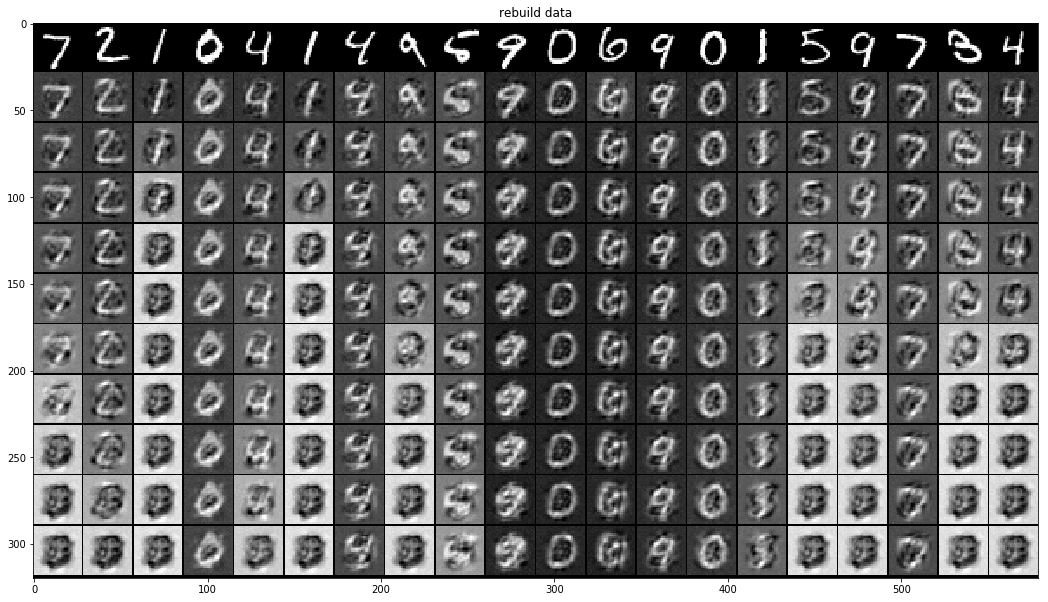

In [4]:
n_iter=1
# generate images by a trained RBM;
t1 = timeit.default_timer()
v_samples = tf.Variable(tf.to_float(test_samples), dtype=tf.float32)
t2=timeit.default_timer()
print("1", t2-t1)
sampler = rbm.sampler(v_samples, steps=n_iter)  # cost too much time, don't know why
t3=timeit.default_timer()
print("2",t3-t2)
new_v_samples = tf.assign(v_samples, sampler)
t4=timeit.default_timer()
print("4",t4-t3)
# store the sampled images
image_data = np.zeros((29*(n_samples+1)+1, 29*(n_chains)-1),
                  dtype="uint8")
# the original images
image_data[0:28,:] = tile_raster_images(X=test_samples,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))
t5=timeit.default_timer()
print("5",t5-t4)
sess.run(tf.variables_initializer(var_list=[v_samples]))
t6=timeit.default_timer()
print("6",t6-t5)
for idx in range(1, n_samples+1):
    #samples = sess.run( sampler )
    samples=sess.run(new_v_samples)
    #if(idx==2):
        #print(samples.tolist())
    print("...sample: ", idx)
    image_data[idx*29:idx*29+28,:] = tile_raster_images( X=samples,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))            

      
image = Image.fromarray(image_data)
image.save("reconstruction.png".format(n_samples))
plt.rcParams['figure.figsize'] = (18.0, 18.0)
plt.imshow(image)
plt.set_cmap('gray') 
plt.title('rebuild data') 
print("finished")

# Three lines of white

...sample:  1
...sample:  2
...sample:  3
...sample:  4
...sample:  5
...sample:  6
...sample:  7
...sample:  8
...sample:  9
...sample:  10
finished


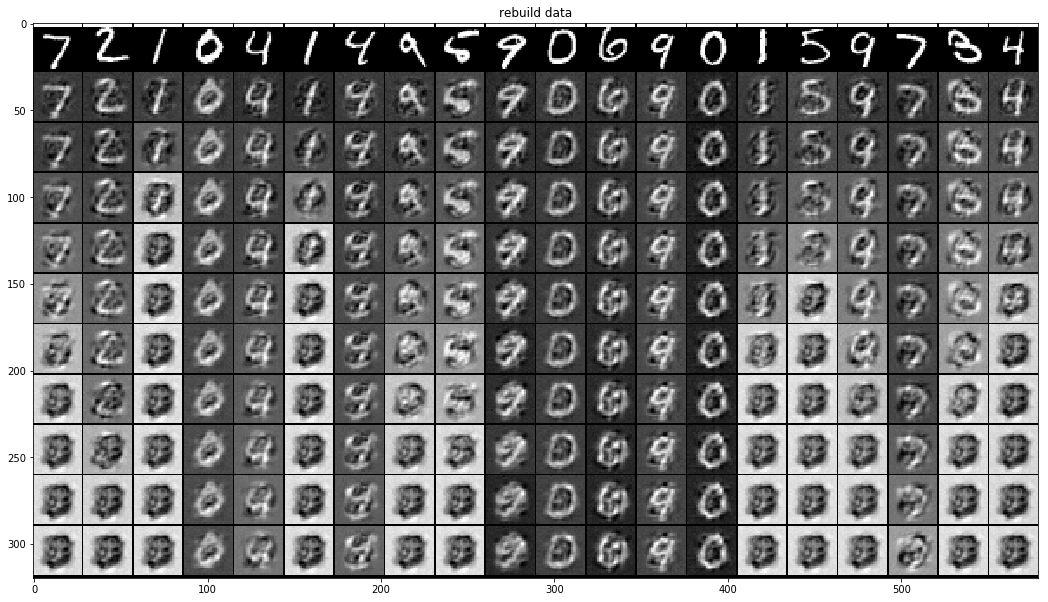

In [5]:
n_iter=1
# store the sampled images
image_data_line = np.zeros((29*(n_samples+1)+1, 29*(n_chains)-1),
                  dtype="uint8")

v_samples = tf.Variable(tf.to_float(test_samples_whiteline), dtype=tf.float32)
sampler = rbm.sampler(v_samples, steps=n_iter)
new_v_samples = tf.assign(v_samples, sampler)
# store the sampled images
image_data_line = np.zeros((29*(n_samples+1)+1, 29*(n_chains)-1),
                  dtype="uint8")
# the original images
image_data_line[0:28,:] = tile_raster_images(X=test_samples_whiteline,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))

sess.run(tf.variables_initializer(var_list=[v_samples]))
for idx in range(1, n_samples+1):
    #v_samples = sess.run( sampler )
    samples=sess.run(new_v_samples)
    print("...sample: ", idx)
    image_data_line[idx*29:idx*29+28,:] = tile_raster_images( X=samples,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))            

      
image = Image.fromarray(image_data_line)
image.save("reconstruction_whiteline.png".format(n_samples))
plt.rcParams['figure.figsize'] = (18.0, 18.0)
plt.imshow(image)
plt.set_cmap('gray') 
plt.title('rebuild data') 
print("finished")

# random noise

...sample:  1
...sample:  2
...sample:  3
...sample:  4
...sample:  5
...sample:  6
...sample:  7
...sample:  8
...sample:  9
...sample:  10
finished


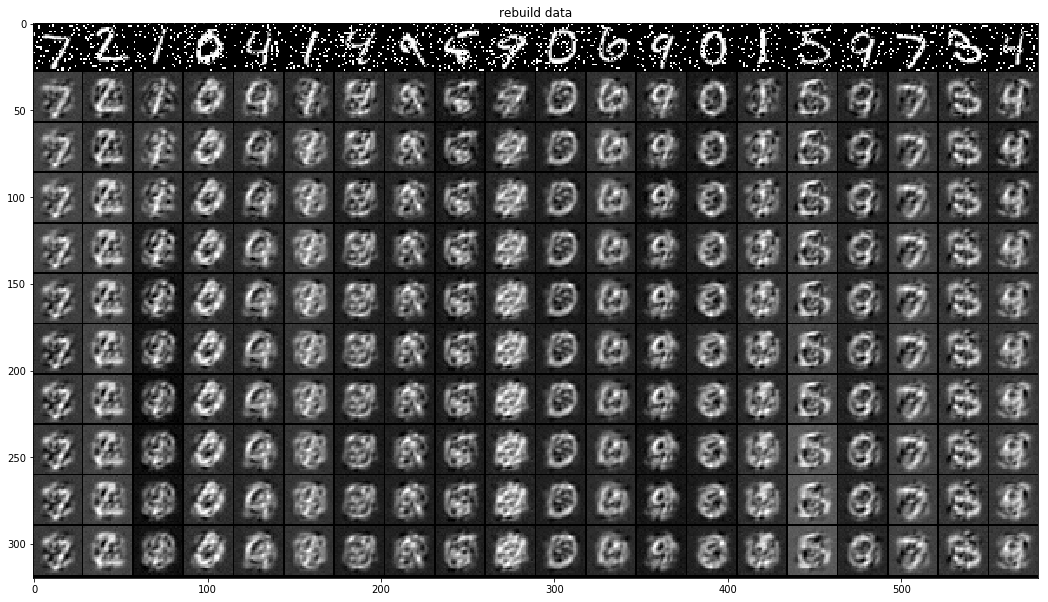

In [6]:
n_iter=1
v_samples = tf.Variable(tf.to_float(test_samples_gaussian), dtype=tf.float32)
sampler = rbm.sampler(v_samples, steps=n_iter)
new_v_samples = tf.assign(v_samples, sampler)
# store the sampled images
image_data_random = np.zeros((29*(n_samples+1)+1, 29*(n_chains)-1),
                  dtype="uint8")
# the original images
image_data_random[0:28,:] = tile_raster_images(X=test_samples_gaussian,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))

sess.run(tf.variables_initializer(var_list=[v_samples]))
for idx in range(1, n_samples+1):
    #v_samples = sess.run( sampler )
    samples=sess.run(new_v_samples)
    print("...sample: ", idx)
    image_data_random[idx*29:idx*29+28,:] = tile_raster_images( X=samples,
                                    img_shape=(28, 28),
                                    tile_shape=(1, n_chains),
                                    tile_spacing=(1, 1))            

      
image = Image.fromarray(image_data_random)
image.save("reconstruction_random.png".format(n_samples))
plt.rcParams['figure.figsize'] = (18.0, 18.0)
plt.imshow(image)
plt.set_cmap('gray') 
plt.title('rebuild data') 
print("finished")

In [7]:
writer=tf.summary.FileWriter('./namescope', graph=tf.get_default_graph())
writer.close()

In [8]:
#sess.close()

In [9]:
type(step)

tuple